## (a) Vanishing Point and Horizon Line:

Vanishing Point: (578.32, 173.07)


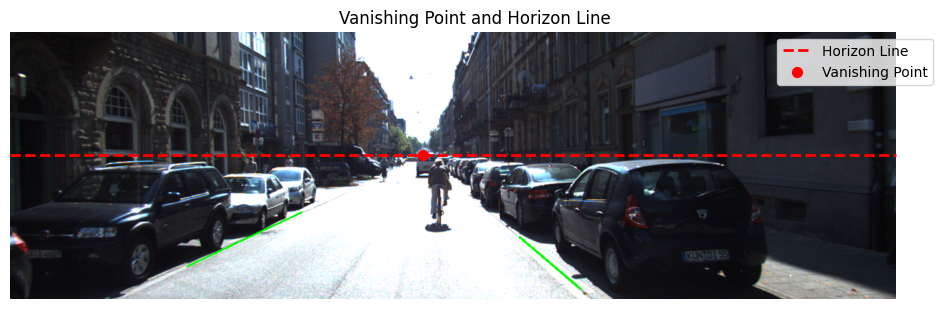

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "Q3.png"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img_rgb.copy()

# Enter the points here: two points for each parallel road edge
# Format: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
# Example:
points = [(248, 329), (409, 253),  # First line
          (799, 360), (714, 288)]  # Second line

# Convert to homogeneous coordinates
p1 = np.array([*points[0], 1])
p2 = np.array([*points[1], 1])
p3 = np.array([*points[2], 1])
p4 = np.array([*points[3], 1])

# Compute the lines
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)

# Compute the vanishing point
vp = np.cross(l1, l2)
vp = vp / vp[2]  # Normalize

print(f"Vanishing Point: ({vp[0]:.2f}, {vp[1]:.2f})")

# Draw the input lines
cv2.line(img_copy, points[0], points[1], (0, 255, 0), 2)
cv2.line(img_copy, points[2], points[3], (0, 255, 0), 2)

# Draw the vanishing point
cv2.circle(img_copy, (int(vp[0]), int(vp[1])), 6, (255, 0, 0), -1)

# Draw the horizon line: horizontal line passing through the vanishing point
x_vals = np.array([0, img.shape[1]])
horizon_y = int(vp[1])
plt.figure(figsize=(12, 6))
plt.imshow(img_copy)
plt.plot(x_vals, [horizon_y, horizon_y], 'r--', linewidth=2, label='Horizon Line')
plt.scatter(vp[0], vp[1], c='red', s=50, label='Vanishing Point')
plt.legend()
plt.title("Vanishing Point and Horizon Line")
plt.axis('off')
plt.show()


## (b) Camera Pitch Angle:

In [2]:
# Camera intrinsic parameters
fy = 980.8141
cy = 233.1966

# Vanishing point (result from previous step)
# Example value: Replace with actual vanishing point from your previous output
vp_y = 180  # Sample value; replace with actual result

# Compute pitch angle
pitch_rad = np.arctan((vp_y - cy) / fy)
pitch_deg = np.degrees(pitch_rad)

print(f"Camera Pitch Angle: {pitch_rad:.4f} rad ({pitch_deg:.2f} degrees)")


Camera Pitch Angle: -0.0542 rad (-3.10 degrees)


## (c) Bird’s Eye View (BEV) Homography:

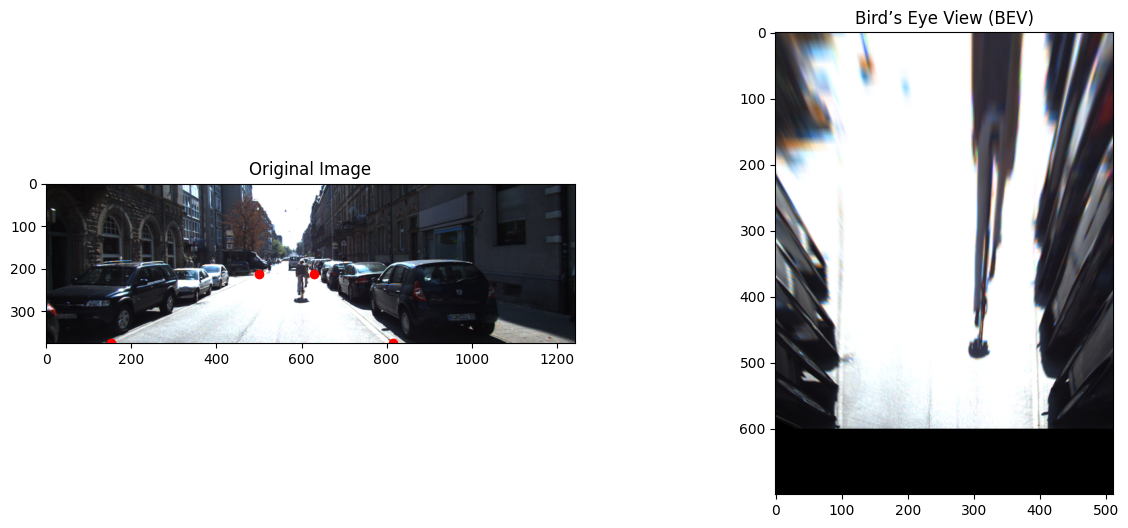

In [3]:
from google.colab import files

# Step 3: Define image and BEV points (these points should be manually adjusted)
# Points on the road in the image (on the ground)
pts_img = np.array([
    [816, 374],  # bottom-right
    [153, 374],  # bottom-left
    [630, 213],  # top-right
    [500, 213]   # top-left
], dtype=np.float32)

# Corresponding points in the BEV (arranged vertically)
pts_bev = np.array([
    [400, 600],  # bottom-right
    [100, 600],  # bottom-left
    [400, 100],  # top-right
    [100, 100]   # top-left
], dtype=np.float32)

# Step 4: Compute the Homography matrix
H, status = cv2.findHomography(pts_img, pts_bev)

# Step 5: Apply the perspective transformation to get BEV
bev_size = (512, 700)  # Size of the BEV image (width, height)
bev_img = cv2.warpPerspective(img_rgb, H, bev_size)

# Display the original image and BEV result
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.scatter(pts_img[:, 0], pts_img[:, 1], c='red')
plt.subplot(1, 2, 2)
plt.imshow(bev_img)
plt.title("Bird’s Eye View (BEV)")
plt.show()


## (d) Road Width and Lane Extraction:

Estimated road width: 15.00 meters
Estimated right lane width: 7.50 meters


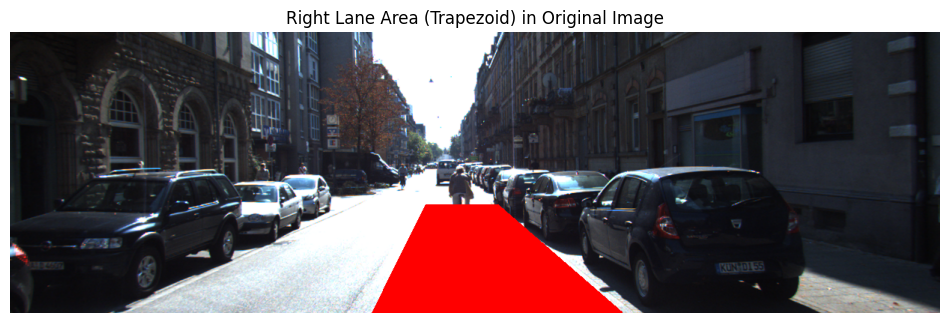

In [4]:
# Parameters
bev_scale_m_per_px = 0.05  # Each pixel in BEV corresponds to how many meters (assumed value - should be adjusted for real data)

# Points in BEV representing the road edges (as defined earlier)
left_point_bev  = np.array([100, 600, 1])  # bottom-left
right_point_bev = np.array([400, 600, 1])  # bottom-right

# Pixel distance between the two road edges in BEV
road_width_px = np.linalg.norm(right_point_bev[:2] - left_point_bev[:2])

# Convert to meters
road_width_m = road_width_px * bev_scale_m_per_px
right_lane_width_m = road_width_m / 2

print(f"Estimated road width: {road_width_m:.2f} meters")
print(f"Estimated right lane width: {right_lane_width_m:.2f} meters")

# -----------------------
# 🔍 Extracting the rightmost lane in the original image:

# Find corresponding points in the original image from BEV using H⁻¹
H_inv = np.linalg.inv(H)

# Points on the right side of the road in BEV
# Assuming the bottom is closer to the camera
right_lane_bev = np.array([
    [250, 600, 1],  # bottom-left of right lane
    [400, 600, 1],  # bottom-right
    [400, 300, 1],  # top-right
    [250, 300, 1]   # top-left of right lane
]).T  # 3×4 for matrix multiplication

# Convert to original image coordinates using H⁻¹
right_lane_img = H_inv @ right_lane_bev
right_lane_img = right_lane_img / right_lane_img[2]  # normalize

# Extract only x, y
pts_img = right_lane_img[:2].T.astype(np.int32)

# Draw the area on the image
img_lane_poly = img_rgb.copy()
cv2.polylines(img_lane_poly, [pts_img], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.fillPoly(img_lane_poly, [pts_img], color=(255, 0, 0))

# Show the result
plt.figure(figsize=(12, 6))
plt.imshow(img_lane_poly)
plt.title("Right Lane Area (Trapezoid) in Original Image")
plt.axis('off')
plt.show()


## (e) Ground Plane Normal Extraction:

In [5]:
# Camera intrinsic parameters
K = np.array([
    [984.2439, 0.0, 690.0],
    [0.0, 980.8141, 233.1966],
    [0.0, 0.0, 1.0]
])

# A point on the horizon line: we assume it's the same vanishing point from earlier
vp = np.array([vp[0], vp[1], 1.0])  # Use actual value from previous context

# Backprojecting the point into a 3D ray in the camera frame
K_inv = np.linalg.inv(K)
ray = K_inv @ vp
ray = ray / np.linalg.norm(ray)  # Normalize the ray

# The ground plane normal is perpendicular to this ray and should point downward
# Assuming the ground is at z=0, the normal should align with the negative Y-axis in camera space
# Therefore, the ground normal can be orthogonal to the ray

n_cam = np.cross(ray, [1, 0, 0])  # A vector perpendicular to the ray (e.g., x-axis)
n_cam = np.cross(n_cam, ray)      # Cross again to get normal vector orthogonal to both

n_cam = n_cam / np.linalg.norm(n_cam)

print("Ground Plane Normal in Camera Frame:")
print(n_cam)


Ground Plane Normal in Camera Frame:
[ 0.9936478  -0.00688553  0.11232381]


## (f) Depth Estimation from Object Detection Using Ground Normal:

In [6]:
n = n_cam  # Should come from the previous step and be normalized

# Camera height from the ground
h = 1.65  # meters

# Contact point of the object with the ground (bottom center of the bicycle box)
# For example, if the bounding box of the bicycle is (xmin, ymin, xmax, ymax) = (300, 200, 360, 400)
bbox = (585, 274, 617, 205)
u = (bbox[0] + bbox[2]) / 2
v = bbox[3]  # Bottom of the box
p_img = np.array([u, v, 1.0])

# Ray direction in camera coordinate system
r = K_inv @ p_img
r = r / np.linalg.norm(r)

# Compute scale (λ)
lambda_ = h / (n @ r)

# Contact point in camera coordinate system
X = lambda_ * r

# Depth (distance to the object along z-axis)
depth = X[2]

print(f"Estimated depth of the bicycle: {depth:.2f} meters")


Estimated depth of the bicycle: 72.78 meters


## (g) Extra:

In [7]:
!pip install -q transformers accelerate timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

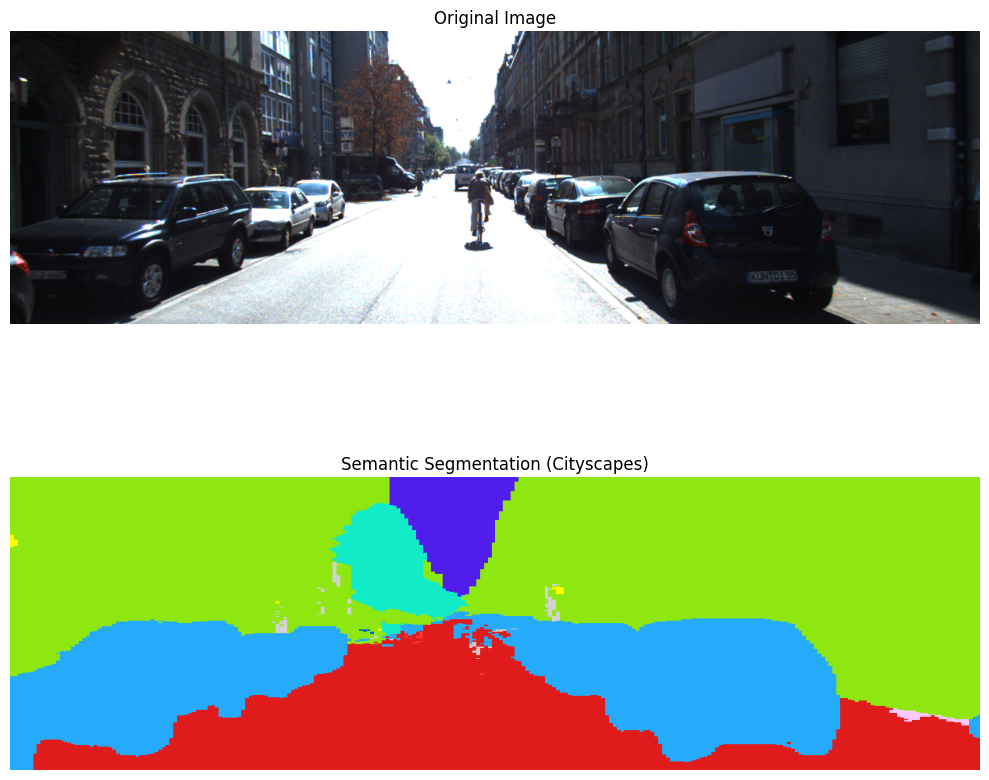

In [8]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 1. Load the pre-trained model on Cityscapes
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").eval()

# 2. Read the input image
img_path = "Q3.png"          # If it's in the current working directory in Colab
image = Image.open(img_path).convert("RGB")
original_width, original_height = image.size

# 3. Preprocess the input
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # shape: (1, num_classes, H, W)

# 4. Get segmentation prediction
seg = logits.argmax(dim=1)[0].cpu().numpy()

# 5. Cityscapes color map (19 classes)
cityscapes_colors = np.array([
    [223, 27, 27],     # 0: road → light pink
    [255, 200, 255],   # 1: sidewalk → very light pink
    [142, 231, 17],    # 2: building → light gray
    [180, 180, 250],   # 3: wall → light purple-blue
    [220, 200, 200],   # 4: fence → dirty pink
    [210, 210, 210],   # 5: pole → light gray
    [255, 200, 0],     # 6: traffic light → golden orange
    [255, 255, 0],     # 7: traffic sign → bright yellow
    [18, 235, 199],    # 8: vegetation → neon green
    [180, 250, 180],   # 9: terrain → light green
    [81, 29, 235],     # 10: sky → light sky blue
    [255, 50, 50],     # 11: person → bright red
    [255, 0, 127],     # 12: rider → reddish-pink (fuchsia-like)
    [38, 171, 250],    # 13: car → bright blue
    [0, 100, 200],     # 14: truck → medium blue
    [0, 200, 200],     # 15: bus → light turquoise
    [64, 224, 208],    # 16: train → pale sea blue
    [0, 255, 255],     # 17: motorcycle → very light sky blue
    [255, 20, 147],    # 18: bicycle → bright raspberry pink
], dtype=np.uint8)

# 6. Create a colored image from the segmentation mask
seg_color = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for label in range(len(cityscapes_colors)):
    seg_color[seg == label] = cityscapes_colors[label]

# 7. Resize back to original image size (OpenCV expects (width, height))
seg_color_resized = cv2.resize(seg_color, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

# 8. Final display with equal dimensions, shown vertically
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 1, 2)
plt.imshow(seg_color_resized)
plt.title("Semantic Segmentation (Cityscapes)")
plt.axis("off")

plt.tight_layout()
plt.show()
